In [116]:
# imports
import os
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
# Define the path to items folder
items_folder_path = '/Users/MeganWagnerSmith/Desktop/Animal_Crossing_Project/animal-crossing-new-horizons-nookplaza-dataset/'

# List all item files
item_files = [f for f in os.listdir(items_folder_path) if f.endswith('.csv') and f != 'villagers.csv']


In [65]:
# Initialize DataFrame to hold all item data
all_items_df = pd.DataFrame()

# Load each item file and concatenate it to the all_items_df
for file_name in item_files:
    file_path = os.path.join(items_folder_path, file_name)
    temp_df = pd.read_csv(file_path)

In [73]:
# Create DataFrame to store all item data 
# Initialize DataFrame
all_items_df = pd.DataFrame()

for file_name in item_files:
    file_path = os.path.join(items_folder_path, file_name)
    temp_df = pd.read_csv(file_path)

    # Check if 'Buy' column exists in the DataFrame
    if 'Buy' in temp_df.columns:
        temp_df['Buy'].replace('NFS', pd.NA, inplace=True)
        temp_df['Buy'] = pd.to_numeric(temp_df['Buy'], errors='coerce')
    else:
        # Assign NaN if 'Buy' column does not exist
        temp_df['Buy'] = pd.NA

    # Check if 'Sell' column exists
    if 'Sell' in temp_df.columns:
        temp_df['Sell'].replace('NFS', pd.NA, inplace=True)
        temp_df['Sell'] = pd.to_numeric(temp_df['Sell'], errors='coerce')
    else:
        # Assign NaN if 'Sell' column does not exist
        temp_df['Sell'] = pd.NA
    # Select only necessary columns
    if 'Internal ID' in temp_df.columns:
        columns_to_select = ['Internal ID', 'Name', 'Buy', 'Sell']
        temp_df = temp_df[columns_to_select]
        temp_df = temp_df[columns_to_select]
    else:
        # If 'Internal ID' column does not exist, you may choose to skip the file or handle it differently
        continue  # Skip this file
    all_items_df = pd.concat([all_items_df, temp_df])

# Remove duplicates based on the 'Name' column
all_items_df.drop_duplicates(subset=['Internal ID'], inplace=True)

# Display the first few rows of the combined items DataFrame
print(all_items_df.head())

# Check for duplicates
duplicates = all_items_df[all_items_df.duplicated(subset=['Internal ID', 'Name'], keep=False)]
print(duplicates)

   Internal ID                    Name       Buy     Sell
0       3948.0       accessories stand    1500.0    375.0
5      12579.0    ACNH Nintendo Switch   35960.0   8990.0
6       7080.0  agrias butterfly model       NaN   9000.0
7       7453.0      aluminum briefcase  100000.0  25000.0
9        849.0                     amp    5100.0   1275.0
Empty DataFrame
Columns: [Internal ID, Name, Buy, Sell]
Index: []


/var/folders/n9/nhw5lfp14pz9_5f7p9093sd80000gn/T/ipykernel_70791/4248335616.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_items_df = pd.concat([all_items_df, temp_df])
/var/folders/n9/nhw5lfp14pz9_5f7p9093sd80000gn/T/ipykernel_70791/4248335616.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_items_df = pd.concat([all_items_df, temp_df])
/var/folders/n9/nhw5lfp14pz9_5f7p9093sd80000gn/T/ipykernel_70791/4248335616.py:31: FutureWarning: The behavior of DataFrame concatenation with

In [68]:
# Count the total number of NaN values in the 'Internal ID' column
nan_count_internal_id = all_items_df['Internal ID'].isna().sum()
print("Total number of NaN values in 'Internal ID':", nan_count_internal_id)

# Drop NaN values
if nan_count_internal_id > 0:
    all_items_df.dropna(subset=['Internal ID'], inplace=True)

# Convert 'Internal ID' to integers
all_items_df['Internal ID'] = all_items_df['Internal ID'].astype(int)

# Display the first few rows to check the format
print(all_items_df.head())

Total number of NaN values in 'Internal ID': 0
   Internal ID                    Name       Buy     Sell
0         3948       accessories stand    1500.0    375.0
5        12579    ACNH Nintendo Switch   35960.0   8990.0
6         7080  agrias butterfly model       NaN   9000.0
7         7453      aluminum briefcase  100000.0  25000.0
9          849                     amp    5100.0   1275.0


In [94]:
# Load villagers Dataframe
villagers = pd.read_csv(os.path.join(items_folder_path, 'villagers.csv'))

def calculate_home_value(row, items_df):
    # Split the item IDs from furniture list, convert to integers
    furniture_ids = [int(x) for x in row['Furniture List'].split(';')] if pd.notna(row['Furniture List']) else []
    # Filter the all_items_df for the given IDs
    furniture_items = items_df[items_df['Internal ID'].isin(furniture_ids)]
    
    # Use name to filter items_df for wallpaper and flooring
    item_names = [row['Wallpaper'], row['Flooring']]
    wallpaper_flooring_items = items_df[items_df['Name'].isin(item_names)]
    
    # Combine furniture and wallpaper/flooring items
    house_items = pd.concat([furniture_items, wallpaper_flooring_items])
    
    # Calculate total buy and sell values of home decor
    total_decor_buy_value = house_items['Buy'].sum()
    total_decor_sell_value = house_items['Sell'].sum()
    
    return total_decor_buy_value, total_decor_sell_value

# Apply the function to each villager/row in the villagers dataset
villagers[['Total Decor Buy Value', 'Total Decor Sell Value']] = villagers.apply(lambda row: calculate_home_value(row, all_items_df), axis=1, result_type='expand')

# Reorder columns

# Display the DataFrame with the calculated values
print(villagers[['Name', 'Total Decor Buy Value', 'Total Decor Sell Value']].head())
villagers.to_csv('villagers_complete.csv')

      Name  Total Decor Buy Value  Total Decor Sell Value
0  Admiral                18170.0                 11142.0
1  Agent S               102440.0                 28010.0
2    Agnes                58500.0                 20973.0
3       Al                29520.0                 14879.0
4  Alfonso                35200.0                 15010.0


In [101]:
# Calculate average cost to buy home decor, and average resale value
average_buy_value = round(villagers['Total Decor Buy Value'].mean(), 2)
average_sell_value = round(villagers['Total Decor Sell Value'].mean(), 2)

average_buy_value, average_sell_value

(105496.62, 42882.28)

In [103]:
# Calculate the average depreciation rate of home value from purchase cost to selling value
average_depreciation = round(((villagers['Total Decor Buy Value'].mean() - villagers['Total Decor Sell Value'].mean()) / villagers['Total Decor Buy Value'].mean()) * 100, 2)

average_depreciation

59.35

In [108]:
# Sugarshine specific data 

# Load Sugarshine villagers dataset
sugarshine_villagers_df = pd.read_csv('sugarshine_villagers.csv')

# Filter the complete villagers dataset to only show sugarshine villagers, save csv of completed sugarshine dataset
filtered_villagers_df = villagers[villagers['Name'].isin(sugarshine_villagers_df['Name'])]

filtered_villagers_df.to_csv('sugarshine_villagers_complete.csv')


/var/folders/n9/nhw5lfp14pz9_5f7p9093sd80000gn/T/ipykernel_70791/2773006371.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  net_value_plot = sns.barplot(x='Name', y='Net Value', data=sugarshine_df_sorted, palette="viridis")


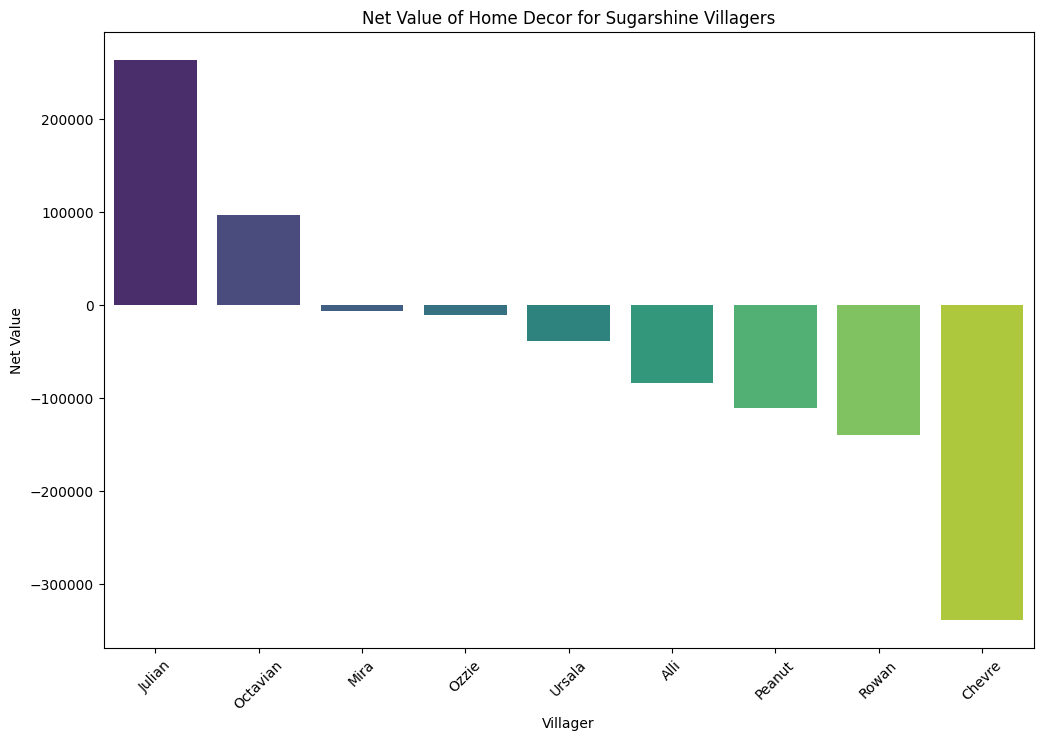

In [124]:
# Calculate Net Value
sugarshine_df['Net Value'] = sugarshine_df['Total Decor Sell Value'] - sugarshine_df['Total Decor Buy Value']

# Sort DataFrame by Net Value
sugarshine_df_sorted = sugarshine_df.sort_values('Net Value', ascending=False)

# Create a bar chart
plt.figure(figsize=(12, 8))
net_value_plot = sns.barplot(x='Name', y='Net Value', data=sugarshine_df_sorted, palette="viridis")
plt.title('Net Value of Home Decor for Sugarshine Villagers')
plt.xlabel('Villager')
plt.ylabel('Net Value')
plt.xticks(rotation=45)


plt.show()